# Assignment: Linear Models, Regularization, and Model Selection on Real Data

Integrantes:

- Calle Chambe, Efraín

- Poma Huamán, Brayan

- Sánchez Vásquez, Barbara Gabriela

## Part A. Linear Regression From Scratch

### 1. **Dataset**
   Use the **California Housing dataset** (`from sklearn.datasets import fetch_california_housing`).

In [ ]:
# Import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.datasets import fetch_california_housing

   * Predict the median house value (`MedHouseVal`) from the remaining features.

In [ ]:
# California Housing dataset

rd = fetch_california_housing(as_frame=True)

X = rd.data
y = rd.target # MedianHouseValue

print(X.shape)
print(y.shape)
print("Features:", X.columns.tolist())
print("Target:", y.name)

(20640, 8)
(20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal


   * Create a hold-out test set.


In [ ]:
# Hold-out set

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=20)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16512, 8)
(4128, 8)
(16512,)
(4128,)


   * Standardize features to zero mean and unit variance

In [ ]:
# Standardize features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Mean: ", X_train_scaled.mean(axis=0))
print("Variance: ", X_train_scaled.std(axis=0))


Mean:  [-8.41273649e-17  8.43425244e-17 -2.53888211e-17 -5.49355996e-16
  6.75600833e-17 -2.58191401e-18 -1.20231129e-15  4.35375250e-15]
Variance:  [1. 1. 1. 1. 1. 1. 1. 1.]



### 2. **Closed-form OLS**


   

   * Derive and implement $\hat\beta = (X^\top X)^{-1}X^\top y$ using only `numpy`.

**Derivating from RSS to Normal Equation**

We know:

$$
\mathrm{RSS}(\beta) = \|Y - X\beta\|_2^2 = (Y - X\beta)^\top (Y - X\beta)
$$
Also:

$$
\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where we define the predicted value as
$$
\hat{y}_i = x_i^\top \beta
$$

So:

$$\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - x_i^\top \beta)^2$$

Deriving:

$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 \sum_{i=1}^{n} x_i^\top (y_i - x_i^\top \beta)
$$

Matrix form:
$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 X^\top (Y - X\beta)
$$

F.O.C.

Then, we do $\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = 0$ to obtain the $\hat{\beta}$ that minimize this loss:

$$
-2 X^\top (Y - X\beta) = 0
$$
$$
X^\top Y - X^\top X \beta = 0
$$

$$
X^\top Y = X^\top X \beta
$$

Then, assuming  $(X^\top X)$ can be inverted, we finally get:

$$
\hat{\beta} = (X^\top X)^{-1} X^\top Y
$$

In [ ]:
# Closed-form OLS

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled] # adding intercept term

beta_hat = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

X_train_b.shape

(16512, 9)

   * Report coefficients and intercept.

In [ ]:
# Report coefficients and intercept

print("Coefficients:", beta_hat[1:])
print("Intercept:", beta_hat[0])

Coefficients: [ 0.83275185  0.1173856  -0.27597663  0.29900186 -0.00795271 -0.03963673
 -0.88241635 -0.85338011]
Intercept: 2.0678235537790726


   * Plot predicted vs. true median house value on a held-out test set.

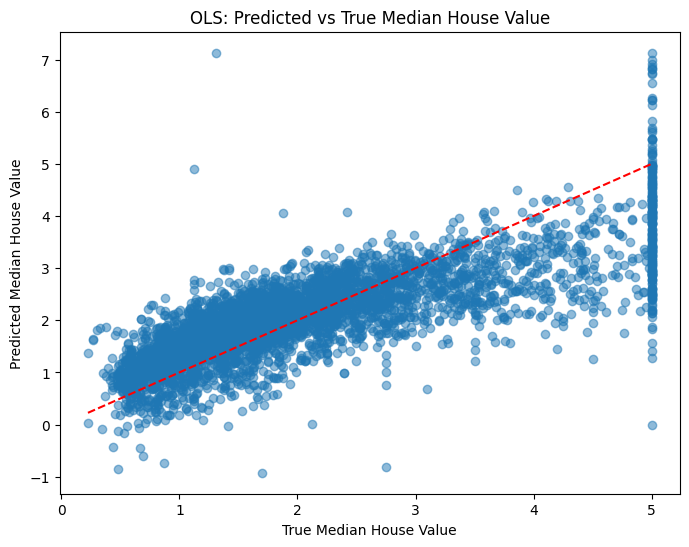

In [ ]:
# Plot predicted vs true on test set

X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled] # adding intercept term
y_pred = X_test_b.dot(beta_hat)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("OLS: Predicted vs True Median House Value")
plt.show()

3. **Gradient Descent**


   * Implement gradient descent to minimize mean squared error.


In [ ]:

def mse(theta, X, y):
    """The cost function, J, describing the goodness of fit.

    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return 0.5*np.mean((y-X.dot(theta))**2)

def mse_gradient(theta, X, y):
    """The gradient of the cost function.

    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets

    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    grad = np.dot(X.T, (np.dot(X, theta) - y)) / X.shape[0] # fixed
    return grad

   * Experiment with at least two learning rates; show cost vs. iteration curves.

In [ ]:
print("=== EXPERIMENT 1: Learning Rate = 0.1 ===")

threshold = 1e-3
step_size = 0.1
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(X_train_b.shape[1]-2)), np.ones(X_train_b.shape[1])
cost_history1 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mse(theta, X_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))

    # Saving the cost for plotting
    cost_history1.append(mse(theta, X_train_b, y_train))

    theta_prev = theta.copy()
    gradient = mse_gradient(theta, X_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost1 = mse(theta, X_train_b, y_train)
cost_history1.append(final_cost1)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost1))

# Saving results
theta_gd1 = theta.copy()
iterations1 = iter

print("Converged in %d iterations" % iterations1)
print("Intercept:", theta_gd1[0])
print("Coefficients:", theta_gd1[1:])
print()



=== EXPERIMENT 1: Learning Rate = 0.1 ===
Iteration 0. MSE: 0.374608
Iteration 100. MSE: 0.273664
Iteration 200. MSE: 0.263972
Iteration 300. MSE: 0.261522
Final iteration 319. MSE: 0.261313
Converged in 319 iterations
Intercept: 2.0678235537790703
Coefficients: [ 0.86527893  0.13094156 -0.32138585  0.32917001 -0.00336916 -0.04170878
 -0.75249279 -0.72664036]



In [ ]:
print("=== EXPERIMENT 2: Learning Rate = 0.5 ===")

threshold = 1e-3
step_size = 0.5
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(X_train_b.shape[1]-2)), np.ones(X_train_b.shape[1])
cost_history2 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mse(theta, X_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))

    # Saving the cost for plotting
    cost_history2.append(mse(theta, X_train_b, y_train))

    theta_prev = theta.copy()
    gradient = mse_gradient(theta, X_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost2 = mse(theta, X_train_b, y_train)
cost_history2.append(final_cost2)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost2))

# Saving results
theta_gd2 = theta.copy()
iterations2 = iter

print("Converged in %d iterations" % iterations2)
print("Intercept:", theta_gd2[0])
print("Coefficients:", theta_gd2[1:])
print()

=== EXPERIMENT 2: Learning Rate = 0.5 ===
Iteration 0. MSE: 0.374608
Iteration 100. MSE: 0.260537
Final iteration 127. MSE: 0.260432
Converged in 127 iterations
Intercept: 2.0678235537790726
Coefficients: [ 0.84256619  0.11958016 -0.29292033  0.31227628 -0.00731143 -0.04008688
 -0.85665873 -0.82874495]



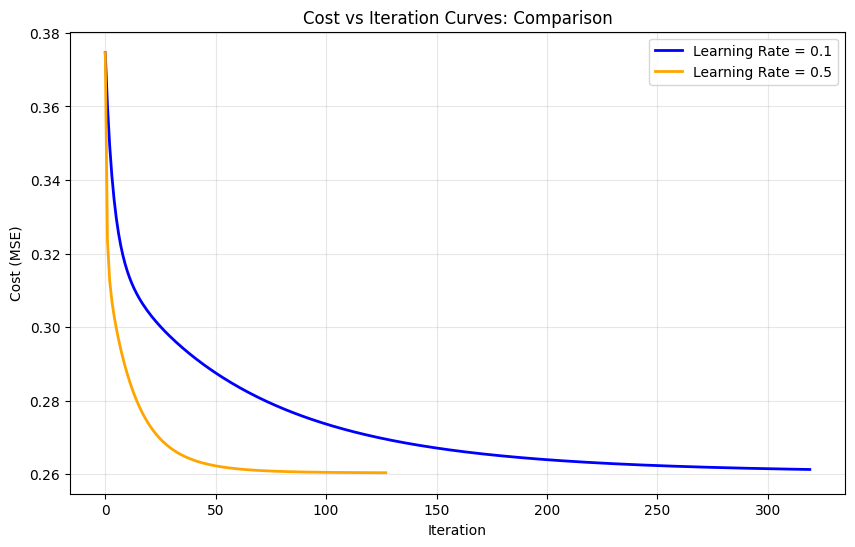

In [ ]:
# Showing cost vs. iteration curves
plt.figure(figsize=(10, 6))
plt.plot(cost_history1, label='Learning Rate = 0.1', linewidth=2, color='blue')
plt.plot(cost_history2, label='Learning Rate = 0.5', linewidth=2, color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Cost vs Iteration Curves: Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

   * Compare parameters and test error to the closed-form OLS.

In [ ]:
# COMPARE PARAMETERS WITH CLOSED-FORM OLS

print("=== COMPARISON WITH CLOSED-FORM OLS ===")

print("Parameters comparison:")
print("Closed-form OLS:")
print("  Intercept: %.6f" % beta_hat[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(beta_hat[1:]):
    print("%.6f" % coef, end="")
    if i < len(beta_hat[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.1):")
print("  Intercept: %.6f" % theta_gd1[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd1[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd1[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.5):")
print("  Intercept: %.6f" % theta_gd2[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd2[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd2[1:]) - 1:
        print(", ", end="")
print("]")

# Parameter differences
diff1 = np.linalg.norm(theta_gd1 - beta_hat)
diff2 = np.linalg.norm(theta_gd2 - beta_hat)
print("\nParameter differences (L2 norm):")
print("  |θ_GD1 - θ_OLS|: %.8f" % diff1)
print("  |θ_GD2 - θ_OLS|: %.8f" % diff2)

# Test error comparison
test_mse_ols = mse(beta_hat, X_test_b, y_test)
test_mse_gd1 = mse(theta_gd1, X_test_b, y_test)
test_mse_gd2 = mse(theta_gd2, X_test_b, y_test)

print("\nTest Error (MSE):")
print("  Closed-form OLS: %.6f" % test_mse_ols)
print("  Gradient Descent (lr=0.1): %.6f" % test_mse_gd1)
print("  Gradient Descent (lr=0.5): %.6f" % test_mse_gd2)

print("\nTest Error differences:")
print("  |MSE_GD1 - MSE_OLS|: %.8f" % abs(test_mse_gd1 - test_mse_ols))
print("  |MSE_GD2 - MSE_OLS|: %.8f" % abs(test_mse_gd2 - test_mse_ols))

=== COMPARISON WITH CLOSED-FORM OLS ===
Parameters comparison:
Closed-form OLS:
  Intercept: 2.067824
  Coefficients: [0.832752, 0.117386, -0.275977, 0.299002, -0.007953, -0.039637, -0.882416, -0.853380]

Gradient Descent (Learning Rate = 0.1):
  Intercept: 2.067824
  Coefficients: [0.865279, 0.130942, -0.321386, 0.329170, -0.003369, -0.041709, -0.752493, -0.726640]

Gradient Descent (Learning Rate = 0.5):
  Intercept: 2.067824
  Coefficients: [0.842566, 0.119580, -0.292920, 0.312276, -0.007311, -0.040087, -0.856659, -0.828745]

Parameter differences (L2 norm):
  |θ_GD1 - θ_OLS|: 0.19282710
  |θ_GD2 - θ_OLS|: 0.04284153

Test Error (MSE):
  Closed-form OLS: 0.270503
  Gradient Descent (lr=0.1): 0.272973
  Gradient Descent (lr=0.5): 0.270921

Test Error differences:
  |MSE_GD1 - MSE_OLS|: 0.00247018
  |MSE_GD2 - MSE_OLS|: 0.00041803



## Part B. Scikit-learn Linear Models

4. **Baseline**

   * Use `LinearRegression` and confirm the coefficients match your OLS implementation.



In [ ]:
# Entrenar modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Crear DataFrame para comparar coeficientes
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "OLS_from_scratch": beta_hat[1:],
    "LinearRegression_sklearn": lin_reg.coef_
})

# Agregar fila para el intercepto
intercept_df = pd.DataFrame({
    "Feature": ["Intercept"],
    "OLS_from_scratch": [beta_hat[0]],
    "LinearRegression_sklearn": [lin_reg.intercept_]
})

# Concatenar intercepto + coeficientes
coef_table = pd.concat([intercept_df, coef_df], ignore_index=True)

# Mostrar tabla
print(coef_table)

      Feature  OLS_from_scratch  LinearRegression_sklearn
0   Intercept          2.067824                  2.067824
1      MedInc          0.832752                  0.832752
2    HouseAge          0.117386                  0.117386
3    AveRooms         -0.275977                 -0.275977
4   AveBedrms          0.299002                  0.299002
5  Population         -0.007953                 -0.007953
6    AveOccup         -0.039637                 -0.039637
7    Latitude         -0.882416                 -0.882416
8   Longitude         -0.853380                 -0.853380


  * Compute $R^2$ and mean squared error on the test set.

In [ ]:
# Predicciones en test
y_pred_sklearn = lin_reg.predict(X_test_scaled)

# Métricas de desempeño
# mse_test = mean_squared_error(y_test, y_pred_sklearn)
# r2_test = r2_score(y_test, y_pred_sklearn)

print("\nResultados en el conjunto de prueba:")
# print("MSE:", mse_test)
# print("R²:", r2_test)


Resultados en el conjunto de prueba:


## Part C. Regularization and Hyperparameter Choice

### 5. **Ridge and Lasso**
   * Fit `Ridge` and `Lasso` regressions for $\lambda$ values logarithmically spaced between $10^{-3}$ and $10^{2}$.

In [ ]:
nombres=X.columns
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

lambdas=np.logspace(-3,2,)
ridge_coefs=[]
lasso_coefs=[]

for l in lambdas:
    ridge_model=Ridge(alpha=l)
    ridge_model.fit(x_train_scaled,y_train)
    ridge_coefs.append(ridge_model.coef_)

    lasso_model=Lasso(alpha=l)
    lasso_model.fit(x_train_scaled,y_train)
    lasso_coefs.append(lasso_model.coef_)

   * Plot coefficient magnitude vs. $\lambda$ (regularization paths).

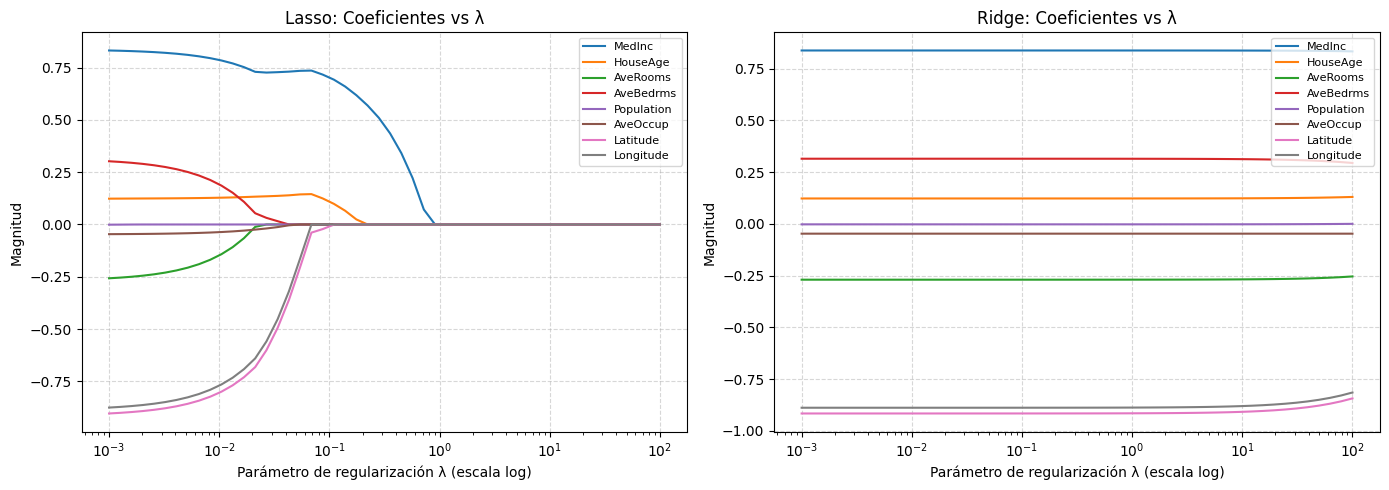

In [ ]:
plt.figure(figsize=(14,5))

# --- Lasso ---
plt.subplot(1,2,1)
plt.plot(lambdas, lasso_coefs)
plt.xscale('log')
plt.title('Lasso: Coeficientes vs λ')
plt.ylabel('Magnitud')
plt.xlabel('Parámetro de regularización λ (escala log)')
plt.legend(nombres, loc='upper right', fontsize=8)
plt.grid(True, ls='--', alpha=0.5)

# --- Ridge ---
plt.subplot(1,2,2)
plt.plot(lambdas, ridge_coefs)
plt.xscale('log')
plt.title('Ridge: Coeficientes vs λ')
plt.xlabel('Parámetro de regularización λ (escala log)')
plt.ylabel('Magnitud')
plt.legend(nombres, loc='upper right', fontsize=8)
plt.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

* Comment on which features shrink to (or toward) zero and why.  
   - La penalización de rigde para los lambdas entrenados ninguno ha convergido cercanamente a cero
   - En la penalización de lasso todas convergen a cero


### 6. **k-Fold Cross-Validation**
   * Use `KFold` with 5 folds and `cross_val_score` to select the best $\alpha$ for both Ridge and Lasso.



In [ ]:
# Kfolds to select the best alpha

ridge_model=Ridge()
lasso_model=Lasso()

K = 5
param_grid = {'alpha': lambdas}
kfold = KFold(K, random_state=0, shuffle=True)

# Modelo Ridge
grid_r = GridSearchCV(ridge_model,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid_r.fit(x_train_scaled, y_train)

# Modelo Lasso
grid_l = GridSearchCV(lasso_model,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid_l.fit(x_train_scaled, y_train)

print(f'''
Mejores alphas con Ridge y Lasso
alpha_lasso:{grid_l.best_params_['alpha']}
alpha_ridge:{grid_r.best_params_['alpha']}
''')



Mejores alphas con Ridge y Lasso
alpha_lasso:0.021209508879201904
alpha_ridge:100.0



   * Alternatively, demonstrate the convenience of `RidgeCV` and `LassoCV`.


In [ ]:
lasso_cv=LassoCV(cv=kfold,
                 alphas=lambdas)
lasso_cv.fit(x_train_scaled,y_train)


ridge_cv=RidgeCV(cv=kfold,
                 alphas=lambdas)
ridge_cv.fit(x_train_scaled,y_train)

print(f'''
Mejores alphas con Ridge_CV y Lasso_CV
alpha_lasso:{lasso_cv.alpha_}
alpha_ridge:{ridge_cv.alpha_}
''')


Mejores alphas con Ridge_CV y Lasso_CV
alpha_lasso:0.021209508879201904
alpha_ridge:100.0



   * Compare cross-validated test errors.

In [ ]:
mse_lassocv=((y_test-lasso_cv.predict(x_test_scaled))**2).mean()
mse_ridgecv=((y_test-ridge_cv.predict(x_test_scaled))**2).mean()
print(f'''
Comparación de mse en los datos de prueba
mse_lasso_cv: {mse_lassocv:.6f}
mse_ridge_cv: {mse_ridgecv:.6f}
''')


Comparación de mse en los datos de prueba
mse_lasso_cv: 0.521915
mse_ridge_cv: 0.517429



### 7. **Feature Engineering & Multicollinearity**

  * Add polynomial features (degree 2) using `PolynomialFeatures`.


In [ ]:
# Todas las combinaciones posibles
polinomios=PolynomialFeatures(degree=2,
                              include_bias=False)
x_train_scaled_poly=polinomios.fit_transform(x_train_scaled)
x_test_scaled_poly=polinomios.transform(x_test_scaled)
pd.DataFrame(x_train_scaled_poly)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.345860,0.415268,-0.603213,0.003807,-0.489613,-0.093357,-1.306158,1.149042,0.119619,-0.143625,...,0.239721,0.045709,0.639512,-0.562586,0.008716,0.121939,-0.107271,1.706049,-1.500830,1.320297
1,-1.260195,-1.324362,-0.069812,0.050412,0.267587,0.030381,0.629466,-0.242279,1.588093,1.668955,...,0.071603,0.008130,0.168437,-0.064831,0.000923,0.019124,-0.007361,0.396228,-0.152507,0.058699
2,-0.475466,0.731565,-0.728046,-0.202796,-0.320263,-0.121451,-0.721731,0.605479,0.226068,-0.347834,...,0.102568,0.038896,0.231143,-0.193912,0.014750,0.087655,-0.073536,0.520895,-0.436993,0.366605
3,-1.350173,0.573417,-0.507868,-0.122030,-0.829200,0.109824,-0.796537,0.670308,1.822967,-0.774212,...,0.687573,-0.091066,0.660489,-0.555819,0.012061,-0.087479,0.073616,0.634472,-0.533925,0.449312
4,-1.051596,1.047862,-0.450710,-0.315212,-0.630590,0.085378,-0.717055,1.124108,1.105855,-1.101928,...,0.397644,-0.053839,0.452168,-0.708852,0.007289,-0.061221,0.095975,0.514168,-0.806047,1.263618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-0.888617,0.019898,-0.037504,0.247908,-0.149139,0.034319,-0.819914,0.680281,0.789640,-0.017682,...,0.022243,-0.005118,0.122281,-0.101457,0.001178,-0.028139,0.023347,0.672260,-0.557772,0.462782
16508,0.121057,-1.877881,0.008770,-0.248466,0.060110,0.005784,0.540633,-0.057767,0.014655,-0.227330,...,0.003613,0.000348,0.032498,-0.003472,0.000033,0.003127,-0.000334,0.292284,-0.031231,0.003337
16509,0.406126,-0.928992,0.616878,-0.045338,-0.180172,0.032103,-0.441205,0.725162,0.164938,-0.377288,...,0.032462,-0.005784,0.079493,-0.130654,0.001031,-0.014164,0.023280,0.194662,-0.319945,0.525861
16510,-1.118922,-0.059176,0.325047,0.296873,0.430730,-0.026192,2.911072,-1.174813,1.251987,0.066214,...,0.185529,-0.011281,1.253887,-0.506028,0.000686,-0.076245,0.030770,8.474340,-3.419966,1.380187


  * Re-run Ridge/Lasso and discuss how regularization copes with the enlarged feature space.

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lasso_cv_poly=LassoCV(cv=kfold,
                 alphas=lambdas)
    lasso_cv_poly.fit(x_train_scaled_poly,y_train)

ridge_cv_poly=RidgeCV(cv=kfold,
                 alphas=lambdas)
ridge_cv_poly.fit(x_train_scaled_poly,y_train)

mse_lasso_poly= ((y_test- lasso_cv_poly.predict(x_test_scaled_poly))**2).mean()
mse_ridge_poly= ((y_test - ridge_cv_poly.predict(x_test_scaled_poly))**2).mean()

print(f'''
Funcion polinomica: lasso vs ridge
mse lasso: {mse_lasso_poly}
mse ridge: {mse_ridge_poly}
''')

KeyboardInterrupt: 

## Part D. Bike Rentals
### Part D.A.
#### 1. **Dataset**




In [ ]:
data = pd.read_csv('data/hour.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
print("Original columns:", data.columns.tolist())
print("Original shape:", data.shape)

Original columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
Original shape: (17379, 17)


Variables que no interesan:
- `instant`
- `dteday`
- `yr`
- `registered` y `casual`: ambos componen la variable target (cnt)


In [ ]:
df = data.drop(columns=['instant','dteday','registered','casual','yr'])

In [ ]:
print("After dropping columns:")
print("New shape:", df.shape)
print("Remaining columns:", df.columns.tolist())

After dropping columns:
New shape: (17379, 12)
Remaining columns: ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


Verificando distribución de las variables

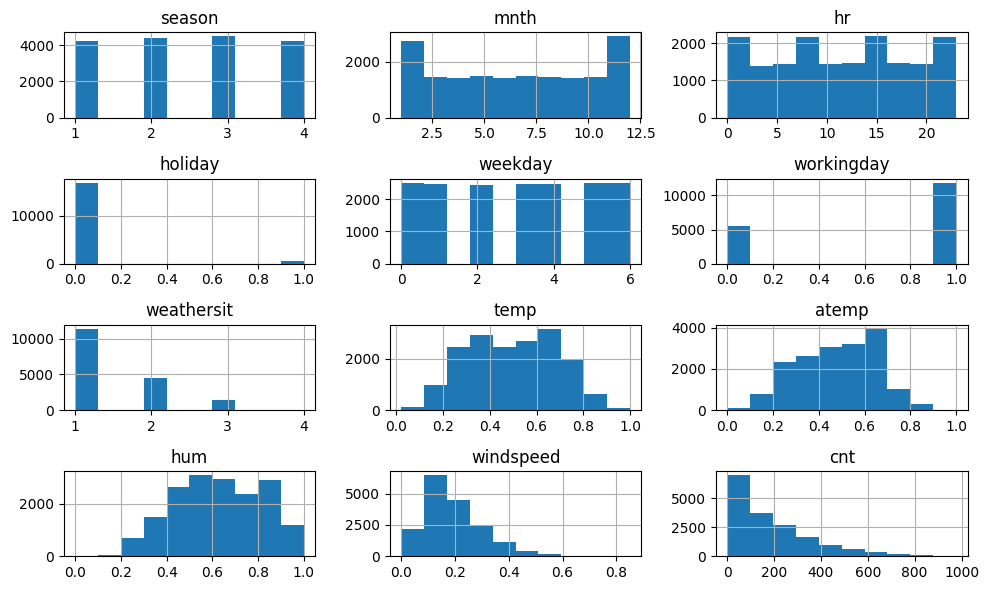

In [ ]:
df.hist(figsize=(10,6))
plt.tight_layout()
plt.show()

Definiendo variables

In [ ]:
categorico = ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
numerico = ['temp', 'atemp', 'hum', 'windspeed','cnt']

Matriz de correlaciones

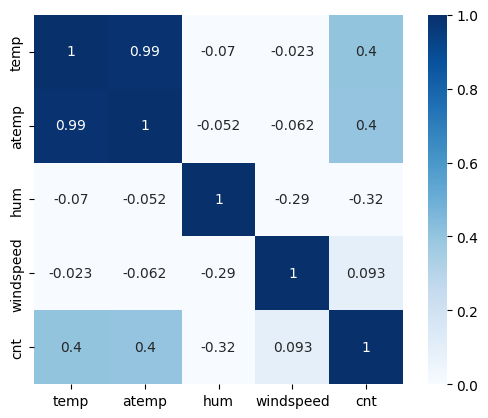

In [ ]:
sns.heatmap(df[numerico].corr(),vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Blues")
plt.show()

Variables perfectamente correlacionadas:
- `temp` y `atemp`
> Debido a esta correlacion excluiremos de las variables de entrada a **atemp** ya que solo uno aporta al modelo

In [ ]:
entrada_categorico = ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
entrada_numerico = ['temp', 'hum', 'windspeed']

**Configuración 1**
- Variables categóricas sin transformar

In [ ]:
X = df[entrada_categorico+entrada_numerico]
Y = df['cnt']
x_train,x_test,y_train,y_test=train_test_split(X,Y,
                                               random_state=159,
                                               test_size=0.2)

# Procesamiento
modelos = {
    "Lineal": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

for nombre, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    train_pred = modelo.predict(x_train)
    test_pred = modelo.predict(x_test)

    print(f"Modelo {nombre}")
    print(f" - MSE entrenamiento: {mean_squared_error(y_train, train_pred):.2f}")
    print(f" - MSE prueba:        {mean_squared_error(y_test, test_pred):.2f}")
    print("-" * 40)

Modelo Lineal
 - MSE entrenamiento: 21560.97
 - MSE prueba:        22597.16
----------------------------------------
Modelo Ridge
 - MSE entrenamiento: 21560.99
 - MSE prueba:        22596.84
----------------------------------------
Modelo Lasso
 - MSE entrenamiento: 21643.24
 - MSE prueba:        22632.81
----------------------------------------


In [ ]:
print("X shape after feature selection:", X.shape)
print("X columns:", X.columns.tolist())
print("Y shape:", Y.shape)
print("Features:", X.columns.tolist())
print("Target: cnt (bike rentals)")

X shape after feature selection: (17379, 10)
X columns: ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']
Y shape: (17379,)
Features: ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']
Target: cnt (bike rentals)


In [ ]:
print("\nData quality check:")
print("X dtypes:")
print(X.dtypes)
print("\nAny missing values in X:")
print(X.isnull().sum())
print("\nAny missing values in Y:")
print(Y.isnull().sum())



Data quality check:
X dtypes:
season          int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
dtype: object

Any missing values in X:
season        0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
dtype: int64

Any missing values in Y:
0


**Configuración 2**
- Variables categóricas transformadas en one hot encoding

In [ ]:
# One hot enconding
df_cat=pd.get_dummies(df[entrada_categorico].astype('object'),
               drop_first=True).astype('int')

# Uniendo datos de entrada
df_entrada=pd.concat([df_cat,df[entrada_numerico]],axis=1)

# Procesamiento
X=df_entrada
Y=df['cnt']
x_train,x_test,y_train,y_test=train_test_split(X,Y,
                                               random_state=159,
                                               test_size=0.2)

modelos = {
    "Lineal": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

for nombre, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    train_pred = modelo.predict(x_train)
    test_pred = modelo.predict(x_test)

    print(f"Modelo {nombre}")
    print(f" - MSE entrenamiento: {mean_squared_error(y_train, train_pred):.2f}")
    print(f" - MSE prueba:        {mean_squared_error(y_test, test_pred):.2f}")
    print("-" * 40)

Modelo Lineal
 - MSE entrenamiento: 12088.06
 - MSE prueba:        12211.13
----------------------------------------
Modelo Ridge
 - MSE entrenamiento: 12089.15
 - MSE prueba:        12214.71
----------------------------------------
Modelo Lasso
 - MSE entrenamiento: 13235.77
 - MSE prueba:        13472.65
----------------------------------------


> Se optará por trabajar por la **segunda configuración** de caracteristicas, el cual tiene sentido ya que en realidad son variables nominales

In [ ]:
# One hot enconding
df_cat_dm=pd.get_dummies(df[entrada_categorico].astype('object'),
               drop_first=True).astype('int')

# Uniendo datos de entrada
df_entrada=pd.concat([df_cat_dm, data[entrada_numerico]],axis=1)

  * Predict daily rentals (`cnt`)
* Create a hold-out test set.



In [ ]:
# Procesamiento
X=df_entrada
Y=df['cnt']
x_train,x_test,y_train,y_test=train_test_split(X,Y,
                                               random_state=159,
                                               test_size=0.2)

In [ ]:
print("\nAfter train_test_split:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("x_train columns:", x_train.columns.tolist())


After train_test_split:
x_train shape: (13903, 51)
x_test shape: (3476, 51)
y_train shape: (13903,)
y_test shape: (3476,)
x_train columns: ['season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'temp', 'hum', 'windspeed']


   * Standardize features to zero mean and unit variance


In [ ]:
# Standardize features
print("\nBefore standardization:")
print("x_train shape:", x_train.shape)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("\nAfter standardization:")
print("x_train_scaled shape:", x_train_scaled.shape)
print("x_test_scaled shape:", x_test_scaled.shape)
print("Mean: ", x_train_scaled.mean(axis=0))
print("Variance: ", x_train_scaled.std(axis=0))


Before standardization:
x_train shape: (13903, 51)

After standardization:
x_train_scaled shape: (13903, 51)
x_test_scaled shape: (3476, 51)
Mean:  [-2.04428608e-18  3.06642913e-18  4.82962587e-17  3.88414356e-17
 -2.35092900e-17  1.99317893e-17  7.15500130e-18  3.65416138e-17
  8.91819804e-17  4.34410793e-17  1.45655384e-17 -4.08857217e-18
  2.24871469e-17 -7.15500130e-18 -6.84835838e-17 -4.49742939e-17
 -5.51957243e-17 -1.02214304e-17 -4.39521508e-17  1.17546450e-17
 -1.10391449e-16 -5.00850091e-17 -4.39521508e-17  8.17714434e-18
  1.27767880e-17  1.07325019e-17  2.96421482e-17  7.87050142e-17
 -1.43100026e-17 -6.95057269e-17  8.38157295e-17 -5.26403667e-17
  8.25380507e-17  1.22657165e-17  1.14991092e-17  1.63542887e-17
 -1.53321456e-17 -5.11071521e-18 -5.34069740e-17  1.02214304e-17
  3.16864343e-17 -8.17714434e-18 -9.71035890e-18 -1.02214304e-17
  1.19590736e-16 -3.06642913e-18 -6.13285825e-18  4.08857217e-18
  2.21805040e-16 -5.72400104e-17  2.04109189e-16]
Variance:  [1. 1. 1. 

#### 2. **Closed-form OLS**

  * Derive and implement $\hat\beta = (X^\top X)^{-1}X^\top y$ using only `numpy`.

In [ ]:
# (The mathematical derivation is the same as in Part A)

In [ ]:
# Closed-form OLS
x_train_b = np.c_[np.ones((x_train_scaled.shape[0], 1)), x_train_scaled]  # adding intercept term

beta_hat = np.linalg.inv(x_train_b.T.dot(x_train_b)).dot(x_train_b.T).dot(y_train)

print("Design matrix shape:", x_train_b.shape)

Design matrix shape: (13903, 52)


   * Report coefficients and intercept.

In [ ]:
# Report coefficients and intercept
print("Coefficients:", beta_hat[1:])
print("Intercept:", beta_hat[0])

Coefficients: [ 16.52398142  10.59376851  27.84281926   0.47178367   1.11233047
  -1.91188918   0.53801415  -5.93482815 -11.49319768  -3.93597622
   4.05210597   1.56843011  -4.09606745  -1.94374808  -3.30298869
  -4.78398084  -6.56252318  -7.1962529   -4.0172357    7.56945441
  33.95589682  61.73433602  32.02256333  21.20115518  25.19317081
  31.77049928  32.20270153  28.13213169  30.89948833  42.50471193
  73.80503894  66.02472325  45.31101761  30.35502368  20.67181699
  13.67335446   6.23583839  -2.41258494  -2.76466633  -2.75773951
  -6.93952763  -3.27955444   0.25656935   4.54007163   7.01333337
  -2.58009782 -16.80677082  -0.47917647  56.67284997 -22.00988686
  -5.64450911]
Intercept: 188.54736387829965


   * Plot predicted vs. true median house value on a held-out test set.

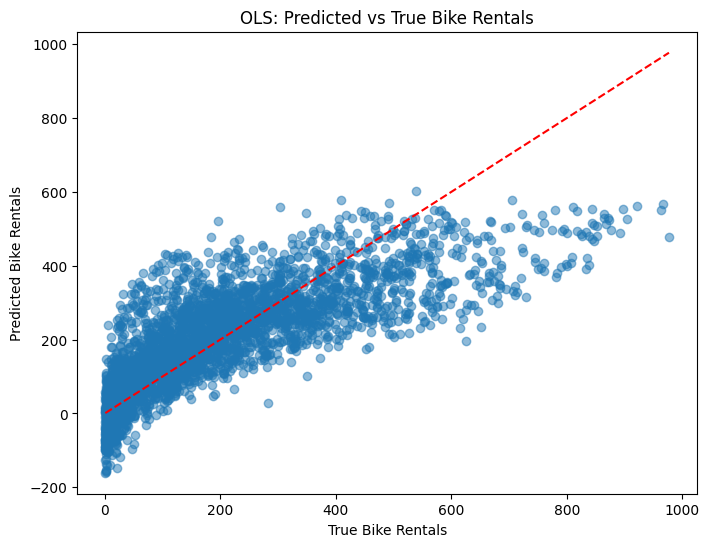

In [ ]:
# Plot predicted vs true on test set
x_test_b = np.c_[np.ones((x_test_scaled.shape[0], 1)), x_test_scaled]  # adding intercept term
y_pred = x_test_b.dot(beta_hat)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.title("OLS: Predicted vs True Bike Rentals")
plt.show()

### 3. **Gradient Descent**

 * Implement gradient descent to minimize mean squared error.

In [ ]:
# (The same functions defined in Part A)

* Experiment with at least two learning rates; show cost vs. iteration curves.

In [ ]:
print("=== EXPERIMENT 1: Learning Rate = 0.1 ===")

threshold = 1e-3
step_size = 0.1
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(x_train_b.shape[1]-2)), np.ones(x_train_b.shape[1])
cost_history1 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mse(theta, x_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))

    # Saving the cost for plotting
    cost_history1.append(mse(theta, x_train_b, y_train))

    theta_prev = theta.copy()
    gradient = mse_gradient(theta, x_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost1 = mse(theta, x_train_b, y_train)
cost_history1.append(final_cost1)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost1))

# Saving results
theta_gd1 = theta.copy()
iterations1 = iter

print("Converged in %d iterations" % iterations1)
print("Intercept:", theta_gd1[0])
print("Coefficients:", theta_gd1[1:])
print()


=== EXPERIMENT 1: Learning Rate = 0.1 ===
Iteration 0. MSE: 33780.901204
Iteration 100. MSE: 6180.762639
Iteration 200. MSE: 6102.195461
Iteration 300. MSE: 6069.079352
Iteration 400. MSE: 6054.953119
Iteration 500. MSE: 6048.876525
Iteration 600. MSE: 6046.233766
Iteration 700. MSE: 6045.066195
Iteration 800. MSE: 6044.538630
Iteration 900. MSE: 6044.292750
Iteration 1000. MSE: 6044.173456
Iteration 1100. MSE: 6044.112723
Iteration 1200. MSE: 6044.080137
Iteration 1300. MSE: 6044.061725
Iteration 1400. MSE: 6044.050832
Iteration 1500. MSE: 6044.044142
Iteration 1600. MSE: 6044.039915
Iteration 1700. MSE: 6044.037191
Iteration 1800. MSE: 6044.035411
Final iteration 1889. MSE: 6044.034343
Converged in 1889 iterations
Intercept: 188.54736387829956
Coefficients: [ 16.38870434  10.42647937  27.73826417   0.49860952   1.17991349
  -1.77724191   0.68921923  -5.77654826 -11.3077746   -3.76898323
   4.21689582   1.67965254  -3.98310715  -1.8676051   -3.30943663
  -4.7896614   -6.57093112  -7.2

In [ ]:
print("=== EXPERIMENT 2: Learning Rate = 0.5 ===")

threshold = 1e-3
step_size = 0.5
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(x_train_b.shape[1]-2)), np.ones(x_train_b.shape[1])
cost_history2 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mse(theta, x_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))

    # Saving the cost for plotting
    cost_history2.append(mse(theta, x_train_b, y_train))

    theta_prev = theta.copy()
    gradient = mse_gradient(theta, x_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost2 = mse(theta, x_train_b, y_train)
cost_history2.append(final_cost2)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost2))

# Saving results
theta_gd2 = theta.copy()
iterations2 = iter

print("Converged in %d iterations" % iterations2)
print("Intercept:", theta_gd2[0])
print("Coefficients:", theta_gd2[1:])
print()

=== EXPERIMENT 2: Learning Rate = 0.5 ===
Iteration 0. MSE: 33780.901204
Iteration 100. MSE: 6048.715749
Iteration 200. MSE: 6044.167989
Iteration 300. MSE: 6044.043787
Iteration 400. MSE: 6044.033407
Iteration 500. MSE: 6044.032093
Final iteration 537. MSE: 6044.031987
Converged in 537 iterations
Intercept: 188.54736387829962
Coefficients: [ 16.48562739  10.55703571  27.82099934   0.47437887   1.12525028
  -1.87835309   0.57702151  -5.90121845 -11.45486116  -3.91170884
   4.08908367   1.58633245  -4.06871817  -1.93009438  -3.30295499
  -4.78303416  -6.56410582  -7.19648644  -4.01658398   7.57044082
  33.95592926  61.73404816  32.01965956  21.20245741  25.19406413
  31.77118853  32.20406996  28.13169362  30.89921094  42.50671084
  73.80826755  66.02753278  45.31228222  30.35567335  20.67368787
  13.67469356   6.23718877  -3.67537706  -1.05425719   0.08848649
   0.91115452   0.71173258   2.12268602   4.54026819   3.41688253
  -2.57950597 -16.80704326  -0.47898123  56.65909617 -22.010081

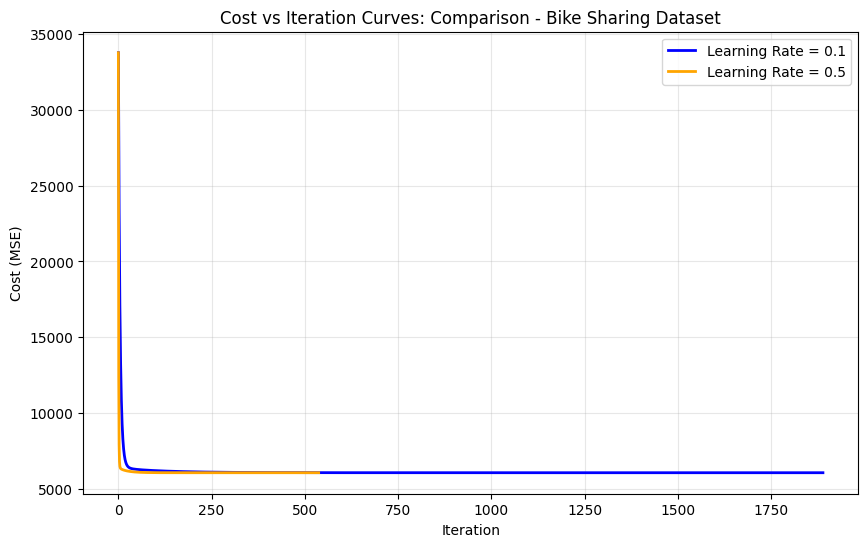

In [ ]:
# Showing cost vs. iteration curves
plt.figure(figsize=(10, 6))
plt.plot(cost_history1, label='Learning Rate = 0.1', linewidth=2, color='blue')
plt.plot(cost_history2, label='Learning Rate = 0.5', linewidth=2, color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Cost vs Iteration Curves: Comparison - Bike Sharing Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

   * Compare parameters and test error to the closed-form OLS.

In [ ]:
# COMPARE PARAMETERS WITH CLOSED-FORM OLS

print("=== COMPARISON WITH CLOSED-FORM OLS ===")

print("Parameters comparison:")
print("Closed-form OLS:")
print("  Intercept: %.6f" % beta_hat[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(beta_hat[1:]):
    print("%.6f" % coef, end="")
    if i < len(beta_hat[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.1):")
print("  Intercept: %.6f" % theta_gd1[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd1[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd1[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.5):")
print("  Intercept: %.6f" % theta_gd2[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd2[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd2[1:]) - 1:
        print(", ", end="")
print("]")

# Parameter differences
diff1 = np.linalg.norm(theta_gd1 - beta_hat)
diff2 = np.linalg.norm(theta_gd2 - beta_hat)
print("\nParameter differences (L2 norm):")
print("  |θ_GD1 - θ_OLS|: %.8f" % diff1)
print("  |θ_GD2 - θ_OLS|: %.8f" % diff2)

# Test error comparison
test_mse_ols = mse(beta_hat, x_test_b, y_test)
test_mse_gd1 = mse(theta_gd1, x_test_b, y_test)
test_mse_gd2 = mse(theta_gd2, x_test_b, y_test)

print("\nTest Error (MSE):")
print("  Closed-form OLS: %.6f" % test_mse_ols)
print("  Gradient Descent (lr=0.1): %.6f" % test_mse_gd1)
print("  Gradient Descent (lr=0.5): %.6f" % test_mse_gd2)

print("\nTest Error differences:")
print("  |MSE_GD1 - MSE_OLS|: %.8f" % abs(test_mse_gd1 - test_mse_ols))
print("  |MSE_GD2 - MSE_OLS|: %.8f" % abs(test_mse_gd2 - test_mse_ols))

=== COMPARISON WITH CLOSED-FORM OLS ===
Parameters comparison:
Closed-form OLS:
  Intercept: 188.547364
  Coefficients: [16.523981, 10.593769, 27.842819, 0.471784, 1.112330, -1.911889, 0.538014, -5.934828, -11.493198, -3.935976, 4.052106, 1.568430, -4.096067, -1.943748, -3.302989, -4.783981, -6.562523, -7.196253, -4.017236, 7.569454, 33.955897, 61.734336, 32.022563, 21.201155, 25.193171, 31.770499, 32.202702, 28.132132, 30.899488, 42.504712, 73.805039, 66.024723, 45.311018, 30.355024, 20.671817, 13.673354, 6.235838, -2.412585, -2.764666, -2.757740, -6.939528, -3.279554, 0.256569, 4.540072, 7.013333, -2.580098, -16.806771, -0.479176, 56.672850, -22.009887, -5.644509]

Gradient Descent (Learning Rate = 0.1):
  Intercept: 188.547364
  Coefficients: [16.388704, 10.426479, 27.738264, 0.498610, 1.179913, -1.777242, 0.689219, -5.776548, -11.307775, -3.768983, 4.216896, 1.679653, -3.983107, -1.867605, -3.309437, -4.789661, -6.570931, -7.203518, -4.024512, 7.562784, 33.948856, 61.727191, 32.014

* Investigate seasonal effects.


In [ ]:
print("\n=== SEASONAL EFFECTS INVESTIGATION ===")

# With one-hot encoding, we have many more features
feature_names = x_train.columns.tolist()
coefficients = beta_hat[1:]

print("Debug - Final check:")
print(f"Number of feature names: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Create coefficient analysis
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features (by coefficient magnitude):")
for _, row in coef_df.head(10).iterrows():
    print(f"  {row['Feature']:<15}: {row['Coefficient']:>8.4f}")



=== SEASONAL EFFECTS INVESTIGATION ===
Debug - Final check:
Number of feature names: 51
Number of coefficients: 51

Top 10 Most Important Features (by coefficient magnitude):
  hr_17          :  73.8050
  hr_18          :  66.0247
  hr_8           :  61.7343
  temp           :  56.6728
  hr_19          :  45.3110
  hr_16          :  42.5047
  hr_7           :  33.9559
  hr_13          :  32.2027
  hr_9           :  32.0226
  hr_12          :  31.7705


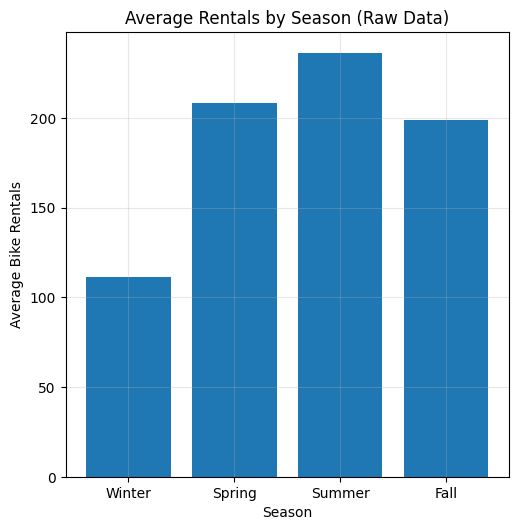

In [ ]:
# Visualize seasonal effects
plt.figure(figsize=(15, 10))
# Average rentals by raw season data
plt.subplot(2, 3, 6)
seasonal_avg = df.groupby('season')['cnt'].mean()
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
plt.bar(seasons, seasonal_avg.values)
plt.xlabel('Season')
plt.ylabel('Average Bike Rentals')
plt.title('Average Rentals by Season (Raw Data)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

El uso de bicicletas presenta un claro patrón estacional: el invierno concentra la menor cantidad de alquileres, mientras que en verano se alcanza el punto máximo. Primavera y otoño muestran valores intermedios, pero aún altos, lo que confirma que el clima es un factor determinante en la demanda del servicio.

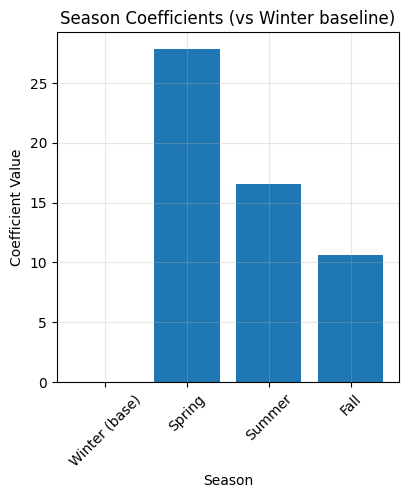

In [ ]:
# Visualize seasonal effects
plt.figure(figsize=(15, 10))
# Seasonal coefficients specifically
plt.subplot(2, 3, 2)
seasonal_features = coef_df[coef_df['Feature'].str.contains('season_')]
if len(seasonal_features) > 0:
    plt.bar(['Winter (base)', 'Spring', 'Summer', 'Fall'],
            [0] + seasonal_features['Coefficient'].tolist())
    plt.xlabel('Season')
    plt.ylabel('Coefficient Value')
    plt.title('Season Coefficients (vs Winter baseline)')
    plt.xticks(rotation=45)
else:
    # Fallback: show original seasonal averages
    seasonal_avg = df.groupby('season')['cnt'].mean()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    plt.bar(seasons, seasonal_avg.values)
    plt.xlabel('Season')
    plt.ylabel('Average Bike Rentals')
    plt.title('Average Rentals by Season')
plt.grid(True, alpha=0.3)

**Interpretación:**

El invierno actúa como categoría base. En comparación, la primavera muestra el mayor incremento esperado, con alrededor de 28 unidades más que el invierno. El verano refleja un aumento de unas 16 unidades y el otoño de unas 10. Todas las estaciones elevan la demanda respecto al invierno, siendo la primavera la de mayor efecto.

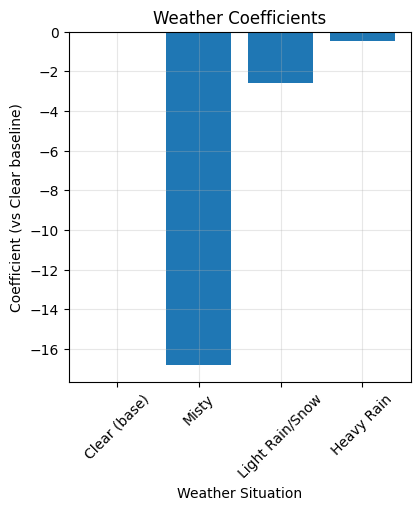

In [ ]:
# Visualize seasonal effects
plt.figure(figsize=(15, 10))
# Weather coefficients
plt.subplot(2, 3, 4)
weather_features = coef_df[coef_df['Feature'].str.contains('weathersit_')]
if len(weather_features) > 0:
    plt.bar(['Clear (base)', 'Misty', 'Light Rain/Snow', 'Heavy Rain'][:len(weather_features)+1],
            [0] + weather_features['Coefficient'].tolist())
    plt.xlabel('Weather Situation')
    plt.ylabel('Coefficient (vs Clear baseline)')
    plt.title('Weather Coefficients')
    plt.xticks(rotation=45)
else:
    # Fallback: show original weather averages
    weather_avg = df.groupby('weathersit')['cnt'].mean()
    weather_labels = ['Clear', 'Misty', 'Light Rain/Snow', 'Heavy Rain'][:len(weather_avg)]
    plt.bar(weather_labels, weather_avg.values)
    plt.xlabel('Weather Situation')
    plt.ylabel('Average Bike Rentals')
    plt.title('Average Rentals by Weather')
    plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

**Interpretación:**

El clima despejado es la base. En comparación, la neblina reduce en promedio 16 unidades en cnt (número total de bicicletas alquiladas), la lluvia ligera o nieve cerca de 2, y la lluvia fuerte menos de 1. En resumen, todas las condiciones climáticas disminuyen la demanda, siendo la neblina la de mayor impacto negativo.


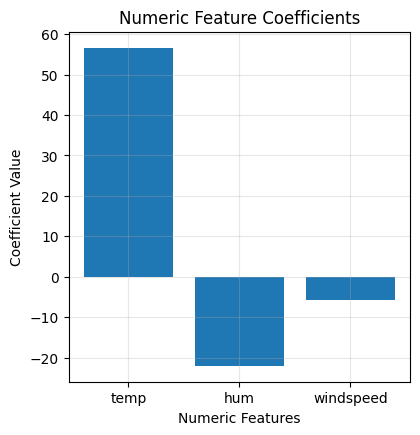

In [ ]:
# Visualize seasonal effects
plt.figure(figsize=(15, 10))
# Temperature, humidity, windspeed
plt.subplot(2, 3, 5)
numeric_features = coef_df[coef_df['Feature'].isin(['temp', 'hum', 'windspeed'])]
plt.bar(numeric_features['Feature'], numeric_features['Coefficient'])
plt.xlabel('Numeric Features')
plt.ylabel('Coefficient Value')
plt.title('Numeric Feature Coefficients')
plt.grid(True, alpha=0.3)

**Interpretación:**

En las variables numéricas, un aumento de una unidad en la temperatura (escala normalizada) se asocia con un incremento de aproximadamente 57 unidades en cnt (número total de bicicletas alquiladas), lo que confirma que temperaturas más altas impulsan la demanda. En contraste, la humedad reduce en promedio 22 unidades y la velocidad del viento alrededor de 6. En conjunto, la temperatura es el factor con mayor efecto positivo, mientras que la humedad y el viento influyen de forma negativa, siendo la humedad el factor más determinante en la caída de la demanda.

El modelo, mediante one-hot encoding, permitió identificar los efectos individuales de cada categoría sobre cnt (número total de bicicletas alquiladas). Se evidenció que la temperatura impulsa fuertemente la demanda, mientras que el clima adverso la reduce. Además, se confirmaron patrones estacionales con mayor preferencia por los meses cálidos y efectos horarios ligados a traslados y ocio. Finalmente, la inclusión de variables categóricas posibilitó capturar relaciones no lineales que enriquecen la explicación del comportamiento de los usuarios.

## Part D - Part B. Scikit-learn Linear Models
4. **Baseline**

   * Use `LinearRegression` and confirm the coefficients match your OLS implementation.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled, y_train)


coef_df = pd.DataFrame({
    "Feature": df_entrada.columns,              # nombres de las variables
    "OLS_from_scratch": beta_hat[1:],           # coeficientes OLS (sin intercepto)
    "LinearRegression_sklearn": lin_reg.coef_   # coeficientes sklearn
})


intercept_df = pd.DataFrame({
    "Feature": ["Intercept"],
    "OLS_from_scratch": [beta_hat[0]],
    "LinearRegression_sklearn": [lin_reg.intercept_]
})

coef_table = pd.concat([intercept_df, coef_df], ignore_index=True)
print(coef_table)


         Feature  OLS_from_scratch  LinearRegression_sklearn
0      Intercept        188.547364                188.547364
1       season_2         16.523981                 16.509604
2       season_3         10.593769                 10.589207
3       season_4         27.842819                 27.841331
4         mnth_2          0.471784                  0.468338
5         mnth_3          1.112330                  1.111629
6         mnth_4         -1.911889                 -1.903518
7         mnth_5          0.538014                  0.549064
8         mnth_6         -5.934828                 -5.932309
9         mnth_7        -11.493198                -11.491503
10        mnth_8         -3.935976                 -3.947216
11        mnth_9          4.052106                  4.057350
12       mnth_10          1.568430                  1.563202
13       mnth_11         -4.096067                 -4.089884
14       mnth_12         -1.943748                 -1.945535
15          hr_1        

   * Compute $R^2$ and mean squared error on the test set.

In [ ]:
y_pred_test_sklearn = lin_reg.predict(x_test_scaled)

print("MSE (test):", mean_squared_error(y_test, y_pred_test_sklearn))
print("R²  (test):", r2_score(y_test, y_pred_test_sklearn))


MSE (test): 12211.133127696707
R²  (test): 0.6337913727643096


### Parte D - Part C. Regularization and Hyperparameter Choice

5. **Ridge and Lasso**

   * Fit `Ridge` and `Lasso` regressions for $\lambda$ values logarithmically spaced between $10^{-3}$ and $10^{2}$.
   * Plot coefficient magnitude vs. $\lambda$ (regularization paths).
   * Comment on which features shrink to (or toward) zero and why.

In [ ]:
lambdas=np.logspace(-3,2,)
ridge_coefs=[]
lasso_coefs=[]

for l in lambdas:
    ridge_model=Ridge(alpha=l)
    ridge_model.fit(x_train,y_train)
    ridge_coefs.append(ridge_model.coef_)

    lasso_model=Lasso(alpha=l)
    lasso_model.fit(x_train,y_train)
    lasso_coefs.append(lasso_model.coef_)

/tmp/ipython-input-495400795.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


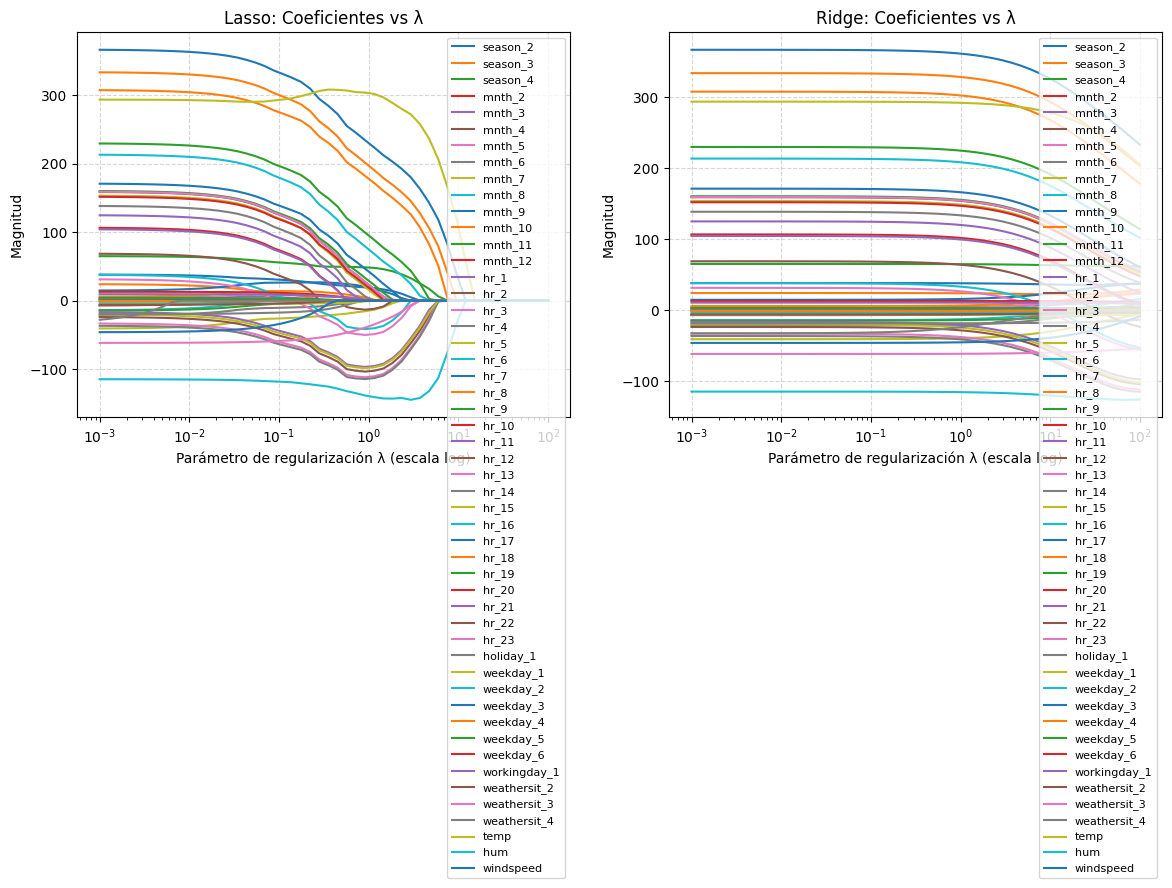

In [ ]:
plt.figure(figsize=(14,5))

# --- Lasso ---
plt.subplot(1,2,1)
plt.plot(lambdas, lasso_coefs)
plt.xscale('log')
plt.title('Lasso: Coeficientes vs λ')
plt.ylabel('Magnitud')
plt.xlabel('Parámetro de regularización λ (escala log)')
plt.legend(df_entrada.columns, loc='upper right', fontsize=8)
plt.grid(True, ls='--', alpha=0.5)

# --- Ridge ---
plt.subplot(1,2,2)
plt.plot(lambdas, ridge_coefs)
plt.xscale('log')
plt.title('Ridge: Coeficientes vs λ')
plt.xlabel('Parámetro de regularización λ (escala log)')
plt.ylabel('Magnitud')
plt.legend(df_entrada.columns, loc='upper right', fontsize=8)
plt.grid(True, ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

6. **k-Fold Cross-Validation**

   * Use `KFold` with 5 folds and `cross_val_score` to select the best $\alpha$ for both Ridge and Lasso.
   * Alternatively, demonstrate the convenience of `RidgeCV` and `LassoCV`.
   * Compare cross-validated test errors.

In [ ]:
# Kfolds to select the best alpha

ridge_model=Ridge()
lasso_model=Lasso()

K = 5
param_grid = {'alpha': lambdas}
kfold = KFold(K, random_state=0, shuffle=True)

# Modelo Ridge
grid_r = GridSearchCV(ridge_model,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid_r.fit(x_train, y_train)

# Modelo Lasso
grid_l = GridSearchCV(lasso_model,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid_l.fit(x_train, y_train)

print(f'''
Mejores alphas con Ridge y Lasso
alpha_lasso:{grid_l.best_params_['alpha']}
alpha_ridge:{grid_r.best_params_['alpha']}
''')


Mejores alphas con Ridge y Lasso
alpha_lasso:0.013257113655901095
alpha_ridge:0.35564803062231287



In [ ]:
lasso_cv=LassoCV(cv=kfold,
                 alphas=lambdas)
lasso_cv.fit(x_train,y_train)

ridge_cv=RidgeCV(cv=kfold,
                 alphas=lambdas)
ridge_cv.fit(x_train,y_train)

print(f'''
Mejores alphas con Ridge_CV y Lasso_CV
alpha_lasso:{lasso_cv.alpha_}
alpha_ridge:{ridge_cv.alpha_}
''')


Mejores alphas con Ridge_CV y Lasso_CV
alpha_lasso:0.013257113655901095
alpha_ridge:0.35564803062231287



In [ ]:
mse_lassocv=((y_test-lasso_cv.predict(x_test))**2).mean()
mse_ridgecv=((y_test-ridge_cv.predict(x_test))**2).mean()

r2_ridge=r2_score(y_test,ridge_cv.predict(x_test))
r2_lasso=r2_score(y_test,lasso_cv.predict(x_test))

print(f'''
Comparación de mse en los datos de prueba
mse_lasso_cv: {mse_lassocv:.6f}
mse_ridge_cv: {mse_ridgecv:.6f}
''')
print(f'''
Comparación de r2 en los datos de prueba
rr2_ridge_cv: {r2_ridge:.6f}
rr2_lasso_cv: {r2_lasso:.6f}
''')


Comparación de mse en los datos de prueba
mse_lasso_cv: 12215.966782
mse_ridge_cv: 12212.185584



7. **Feature Engineering & Multicollinearity**

  * Add polynomial features (degree 2) using `PolynomialFeatures`.
  * Re-run Ridge/Lasso and discuss how regularization copes with the enlarged feature space.

In [ ]:
# Todas las combinaciones posibles exceptuando las variables dummie
polinomios=PolynomialFeatures(degree=2,
                              include_bias=False)
X_num_poly=polinomios.fit_transform(df[entrada_numerico])

X_num_poly=pd.DataFrame(X_num_poly)
X_num_poly.columns = X_num_poly.columns.astype(str)

In [ ]:
import warnings
X=pd.concat([X_num_poly,df_cat_dm],axis=1)
Y=df['cnt']

x_train,x_test,y_train,y_test=train_test_split(X,Y,
                                               random_state=159,
                                               test_size=0.2)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lasso_cv_poly=LassoCV(cv=kfold,
                 alphas=lambdas)
    lasso_cv_poly.fit(x_train,y_train)

    ridge_cv_poly=RidgeCV(cv=kfold,
                 alphas=lambdas)
    ridge_cv_poly.fit(x_train,y_train)

mse_lasso_poly= ((y_test - lasso_cv_poly.predict(x_test))**2).mean()
mse_ridge_poly= ((y_test - ridge_cv_poly.predict(x_test))**2).mean()

print(f'''
Funcion polinomica: lasso vs ridge
mse lasso: {mse_lasso_poly}
mse ridge: {mse_ridge_poly}
''')


Funcion polinomica: lasso vs ridge
mse lasso: 11812.766183611207
mse ridge: 11812.635089516283

